# Documentation

# Code

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio
from pathlib import Path
from time import strftime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import Xception, MobileNetV2

In [2]:
# Define constants
RANDOM_SEED = 42
WIDTH, HEIGHT = 224, 224

## Data exploration

### Load data

In [51]:
future_data = pd.read_csv('future_data_2024.csv')
development_data = pd.read_csv('train_data_2024.csv')

In [52]:
future_data.head()

,FileName
0,Img_1963.jpg
1,Img_7244.jpg
2,Img_6218.jpg
3,Img_7703.jpg
4,Img_6318.jpg


In [53]:
development_data.head()

,FileName,Class,MoreThanOnePerson,HighLevelCategory
0,Img_460.jpg,blowing_bubbles,YES,Social_LeisureActivities
1,Img_8152.jpg,blowing_bubbles,YES,Social_LeisureActivities
2,Img_9056.jpg,jumping,YES,Sports_Recreation
3,Img_3880.jpg,pushing_a_cart,YES,OutdoorActivities
4,Img_3168.jpg,writing_on_a_book,NO,Artistic_MusicalActivities


As we can see, the development data has 3 labels, excluding FileName. We only need to predict the Class and MoreThanOnePerson label. That leaves the HighLevelCategory with no use. However, we could possibly use HighLevelCategory for an aux output layer to help normalize the model if needed

In [54]:
# Validation, check if the data is the same as the assignment description
development_data['Class'].nunique()

40

In [55]:
development_data['FileName'].count()

4500

It seems that future_data does not contain any labels, so we can't use it for evaluation. Therefore, the data from train_data_2024.csv file (development data) will be split into training, testing and validation data. Additionally, development data has the correct number of unique classes as specified in the assignment specification

### Validate images

In this step, we check the detail of the images and validate if there are any missing images from the dataset. If there are, we need to remove the record from the dataframe or there will be problem loading the image data during training. Additionally, since we want the future data to be independent from the training data, we need to check if there are any overlapping image records in the dataframe

In [8]:
# Check if any FileName in train_data also appear in future_data
# Because we want the data to be independent
development_data['FileName'].isin(future_data['FileName']).sum()

0

In [9]:
# Check the size of images
def get_image_size(filepath):
    im = imageio.imread(filepath)
    return im.shape[1], im.shape[0]

def check_images_size(data):
    # List to store the sizes of the images
    sizes = []

    # Iterate through each filename in data['FileName']
    for filename in data['FileName']:
        path = os.path.join('Images', filename)
        # Get the size of the image
        print(path)
        size = get_image_size(path)
        sizes.append(size)

    return sizes

In [10]:
sizes = check_images_size(development_data)

Images\Img_460.jpg
Images\Img_8152.jpg
Images\Img_9056.jpg
Images\Img_3880.jpg
Images\Img_3168.jpg
Images\Img_8609.jpg
Images\Img_3838.jpg
Images\Img_1699.jpg
Images\Img_8543.jpg
Images\Img_1980.jpg
Images\Img_1312.jpg
Images\Img_4514.jpg
Images\Img_3866.jpg
Images\Img_1665.jpg
Images\Img_4231.jpg
Images\Img_8675.jpg
Images\Img_1137.jpg
Images\Img_5918.jpg
Images\Img_951.jpg
Images\Img_5516.jpg
Images\Img_8478.jpg
Images\Img_5152.jpg
Images\Img_2000.jpg
Images\Img_8656.jpg
Images\Img_5416.jpg
Images\Img_4513.jpg
Images\Img_1342.jpg
Images\Img_6016.jpg
Images\Img_7130.jpg
Images\Img_5929.jpg
Images\Img_911.jpg
Images\Img_2077.jpg
Images\Img_949.jpg
Images\Img_997.jpg
Images\Img_991.jpg
Images\Img_4408.jpg
Images\Img_3907.jpg
Images\Img_3098.jpg
Images\Img_7745.jpg
Images\Img_9239.jpg
Images\Img_1290.jpg
Images\Img_1018.jpg
Images\Img_5533.jpg
Images\Img_793.jpg
Images\Img_8428.jpg
Images\Img_2875.jpg
Images\Img_3195.jpg
Images\Img_2888.jpg
Images\Img_2537.jpg
Images\Img_6433.jpg
Images\

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1800\2312564628.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filepath)


Images\Img_4438.jpg
Images\Img_3284.jpg
Images\Img_4934.jpg
Images\Img_2179.jpg
Images\Img_7734.jpg
Images\Img_5645.jpg
Images\Img_8158.jpg
Images\Img_832.jpg
Images\Img_2630.jpg
Images\Img_2404.jpg
Images\Img_5041.jpg
Images\Img_4930.jpg
Images\Img_1743.jpg
Images\Img_7388.jpg
Images\Img_3003.jpg
Images\Img_2954.jpg
Images\Img_5722.jpg
Images\Img_805.jpg
Images\Img_6101.jpg
Images\Img_310.jpg
Images\Img_6.jpg
Images\Img_5420.jpg
Images\Img_297.jpg
Images\Img_3282.jpg
Images\Img_1976.jpg
Images\Img_9230.jpg
Images\Img_6052.jpg
Images\Img_6179.jpg
Images\Img_3330.jpg
Images\Img_7308.jpg
Images\Img_2997.jpg
Images\Img_7335.jpg
Images\Img_3346.jpg
Images\Img_5807.jpg
Images\Img_7114.jpg
Images\Img_601.jpg
Images\Img_3946.jpg
Images\Img_6979.jpg
Images\Img_4523.jpg
Images\Img_350.jpg
Images\Img_8600.jpg
Images\Img_2996.jpg
Images\Img_2845.jpg
Images\Img_7993.jpg
Images\Img_8009.jpg
Images\Img_7789.jpg
Images\Img_7978.jpg
Images\Img_3515.jpg
Images\Img_7544.jpg
Images\Img_8305.jpg
Images\Im

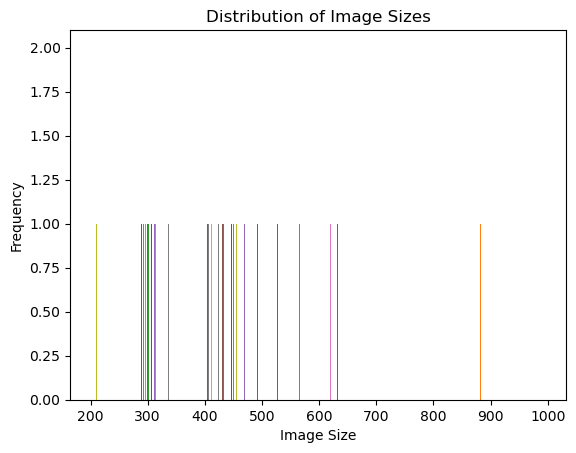

In [11]:
# Plot the sizes
plt.hist(sizes, bins=20)
plt.xlabel('Image Size')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()

From the analysis, there are no file label in development data overlapped with future data, this means that when loading the images, the development data is independent from future data. Additionally, no image is missing from the Image folder after unzip. Additionally, since the images have different sizes, we need to resize them into an uniform size before feeding the data into the model

### Check for data imbalance

We can see that the MoreThanOnePerson occurence for images in each Class is not balanced, and the occurance for each class is not balanced. Additionally, HighLevelCategory is also imbalanced as well. To solve these problems, we might apply:
- Data Augmentation: We can apply data augmentation on the images so that the occurences in each classes is balanced. However, we also need to ensure that the distribution of MoreThanOnePerson label is still balanced
- We could also apply more weight to under-represented classes, or less weight to over-represented classes
- Use transfer learning to reduce overfitting

In this case, since the amount of data in training is not alot, we will apply data augmentation after defining the baseline model to see how well the model performs without any additional modifications or enhancements as well as the impact of data augmentation on the model

<Axes: xlabel='HighLevelCategory'>

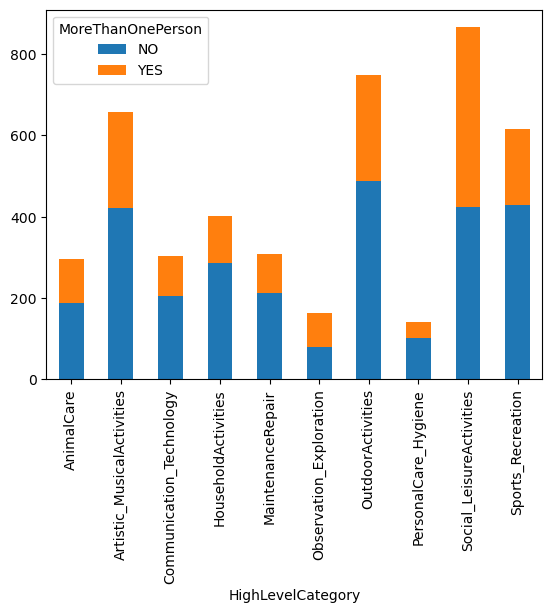

In [71]:
crosstab = pd.crosstab(development_data['HighLevelCategory'], development_data['MoreThanOnePerson'])
crosstab.plot(kind='bar', stacked=True)

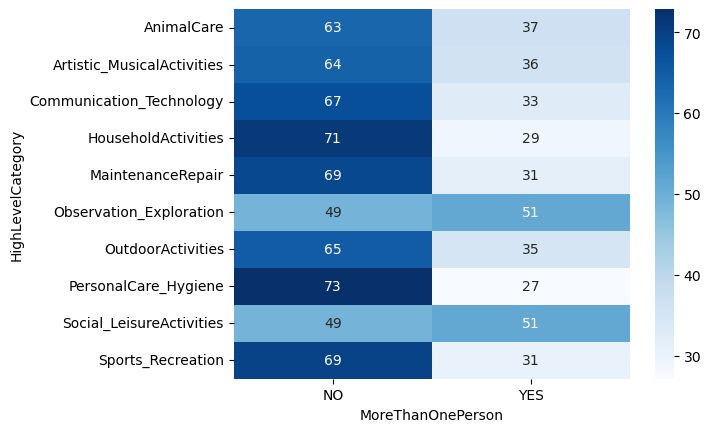

In [72]:
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
sns.heatmap(crosstab_percentage, annot=True, cmap='Blues')
plt.show()

In [68]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(crosstab)
float_value = format(p, '.50f')  #
float_value

'0.00000000000000000000012059205460807055315746846963'

### Prepare data for training

Currently, the format is not suitable for training. The image in the dataframe is only the image file name, while the labels are still strings. Therefore, in this step, we will need to load the images, and one hot encode the labels for training. Additionally, we will only split the data into training and testing, given the dataset's small number of images. 

#### Split data

In [56]:
image_dir = './Images/'

# Get the file paths for each image record
development_data['FilePath'] = development_data['FileName'].apply(lambda x: os.path.join(image_dir, x))
future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join(image_dir, x))

In [57]:
# Currently, the Class and MoreThanOnePerson labels are strings, so we one-hot encode them after splitting
class_encoder = LabelEncoder()
development_data['Class'] = class_encoder.fit_transform(development_data['Class'])
development_data['MoreThanOnePerson'] = development_data['MoreThanOnePerson'].map({'YES': 1, 'NO': 0})

In [58]:
# Save the mappings
class_mapping = dict(enumerate(class_encoder.classes_))
binary_mapping = {1: 'YES', 0: 'NO'}

In [59]:
def load_image(filepath, label=None):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [WIDTH, HEIGHT]) 
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    if label is None:
        return image
    else: 
        return image, label

In [60]:
# Split data
train, test = train_test_split(development_data, test_size=0.2, random_state=RANDOM_SEED, stratify=development_data['Class'])

In [61]:
len(train), len(test)

(3600, 900)

<Axes: xlabel='Class'>

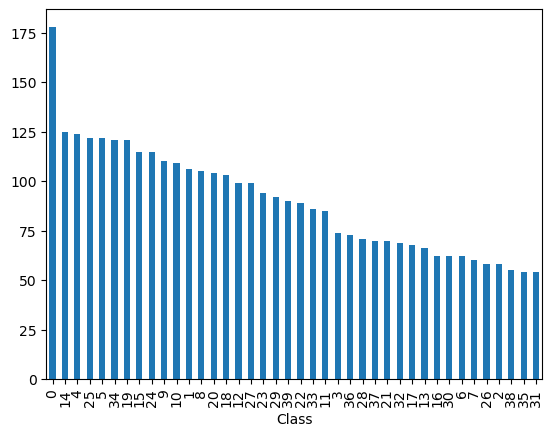

In [62]:
# Check if the distribution of the training data and testing data
train['Class'].value_counts().plot(kind='bar')

<Axes: xlabel='Class'>

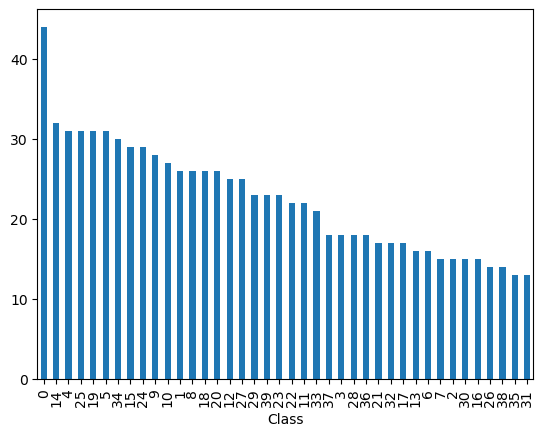

In [63]:
test['Class'].value_counts().plot(kind='bar')

In [64]:
train_ds = tf.data.Dataset.from_tensor_slices((train['FilePath'], {'categorical_output': train['Class'], 'binary_output': train['MoreThanOnePerson']}))
train_ds = train_ds.map(lambda x, y: load_image(x, y)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test['FilePath'], {'categorical_output': test['Class'], 'binary_output': test['MoreThanOnePerson']}))
test_ds = test_ds.map(lambda x, y: load_image(x, y)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

future_ds = tf.data.Dataset.from_tensor_slices((future_data['FilePath']))
future_ds = future_ds.map(lambda x: load_image(x, None)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Visualize and validate dataset

(32, 224, 224, 3)
(32,)
(32,)


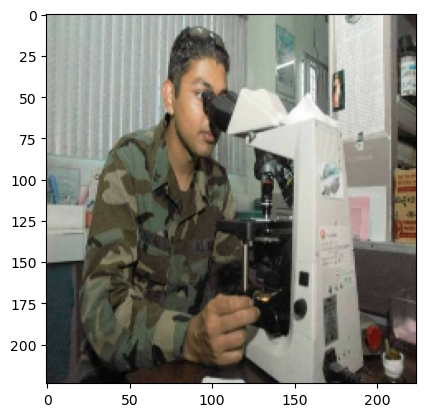

In [65]:
# Validate if the images are loaded correctly
for image, label in test_ds.take(1):
    print(image.shape)
    print(label['categorical_output'].shape)
    print(label['binary_output'].shape)
    plt.imshow(image[0])

(32, 224, 224, 3)
(32,)
(32,)


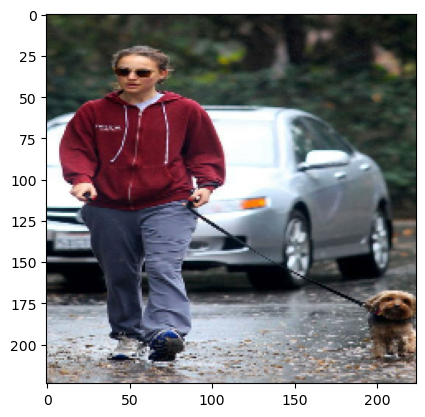

In [66]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label['categorical_output'].shape)
    print(label['binary_output'].shape)
    plt.imshow(image[0])

(32, 224, 224, 3)


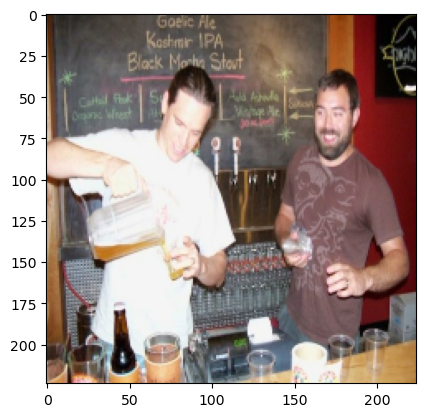

In [67]:
for image in future_ds.take(1):    
    print(image.shape)
    plt.imshow(image[0])

With this, we have split the original development data into training/validation/testing set. We also resized the images into an uniform image size to feed into the model and one hot encode the labels for training. Additionally, we convert the data into a format suitable for inference (tf.data.Dataset) and validate the conversion to ensurre the format is correct. Finally, as we can see from the plots, it seems the data is loaded correctly as the image and label matches each other

## Baseline model

### Helper functions

In [3]:
# Helper function to redefine callbacks
def get_cbs(cbs=[]):
  res_cbs = []
  for cb in cbs:
    res_cbs.append(cb)

  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  res_cbs.append(early_stopping_cb)
  
  return res_cbs

In [4]:
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, history.history['categorical_output_loss'], label='Training Loss (Class)')
    plt.plot(epochs, history.history['val_categorical_output_loss'], label='Validation Loss (Class)')
    plt.title('Training and Validation Loss (Class Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training & validation loss for person output
    plt.figure(figsize=(7, 6))
    plt.plot(epochs, history.history['binary_output_loss'], label='Training Loss (Person)')
    plt.plot(epochs, history.history['val_binary_output_loss'], label='Validation Loss (Person)')
    plt.title('Training and Validation Loss (Person Output)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
# Function to visualize model's predictions on the dataset
def visualize_dev_preds(model, ds, class_mapping):
    image_batch, label_batch = next(iter(ds))
    preds = model.predict(image_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        label1 = tf.argmax(preds[0][i])
        label2 = preds[1][i]
        
        if label2 > 0.5:
            label2 = "YES"
        else:
            label2 = "NO"
        
        plt.title(f'{class_mapping[label1.numpy()]} | {label2}')
        plt.axis("off")

In [6]:
# Function to visualize model's predictions on future_dataset
def visualize_future_preds(model, class_mapping):
    image_batch = next(iter(future_ds))
    preds = model.predict(image_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        label1 = tf.argmax(preds[0][i])
        label2 = preds[1][i]
        
        if label2 > 0.5:
            label2 = "YES"
        else:
            label2 = "NO"
        
        plt.title(f'{class_mapping[label1.numpy()]} | {label2}')
        plt.axis("off")

In [7]:
def heatmap(model, dataset, class_mapping):
    true_labels = []
    true_more_than_one_person = []
    predicted_classes = []
    predicted_more_than_one_person = []

    # Iterate over the entire dataset and collect true and predicted labels
    for images, labels in dataset:
        true_labels.extend(labels['categorical_output'].numpy())  # True class labels
        true_more_than_one_person.extend(labels['binary_output'].numpy())  # True more-than-one-person labels
        prediction = model.predict(images, verbose=False)
        predicted_classes.extend(tf.argmax(prediction[0], axis=1).numpy())
        predicted_more_than_one_person.extend([1 if x >= 0.5 else 0 for x in prediction[1]])

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Confusion matrix for class predictions
    conf_matrix_class = confusion_matrix(true_labels, predicted_classes)
    
    # Convert class_mapping dictionary to lists of class names sorted by class index
    class_labels = [class_mapping[i] for i in range(len(class_mapping))]

    # Plot the heatmap with class names
    sns.heatmap(conf_matrix_class, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix for Class Predictions')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # Confusion matrix for MoreThanOnePerson predictions
    conf_matrix_person = confusion_matrix(true_more_than_one_person, predicted_more_than_one_person)
    sns.heatmap(conf_matrix_person, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NO", "YES"], yticklabels=["NO", "YES"], ax=axes[1])
    axes[1].set_title('Confusion Matrix for MoreThanOnePerson Predictions')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

### Create baseline models

The baseline model is modeled after the overall structure of CNN model for real-time HAR specified in https://link.springer.com/article/10.1007/s11036-019-01445-x paper with modifications to suit our problem. 

Specifically, the original structure have only 1 output layer, however, in our case, the model needs to predict 2 things: Class and MoreThanOnePerson, therefore, our model will have 2 output layers. Since there are 40 classes under the Class label, the first ouput will have 40 neurons, while the second output will have 1 neuron as it is binary classification (YES or NO). Corresponds to the classification type of the outputs, the first output will have softmax activation, while the second output will have sigmoid activation

Additionally, to have more flexibility in improving the model (we want the model to overfit from the start) and due to the complex problem the model needs to solve, the baseline model will have additional Convolution blocks and neurons compared to the original structure to be able to extract more information from the data. For kernel size and pool size, we will use the common size of 3x3 and 2x2 respectively

Furthermore, as the original structure did not specify activation functions for hidden layers, we will use relu for its fast training time and good performance. For optimizer, we use Adam optimizer as it converges fast and require less fine-tuning, making it a time-efficient option for the baseline model. For the loss, since the Class label is one hot encoded, while the MoreThanOnePerson label is converted to 0 and 1, we will use categorical crossentropy and binary crossentropy respectively. 

In [21]:

# Step 1: Define the input layer
input_layer = layers.Input(shape=(224, 224, 3))  # Example input shape (64x64 RGB image)

# Step 2: Create the convolutional base
conv_base = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)
conv_base = layers.Conv2D(64, (3, 3), activation='relu')(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)
conv_base = layers.Conv2D(128, (3, 3), activation='relu')(conv_base)
conv_base = layers.MaxPooling2D((2, 2))(conv_base)

# Step 3: Flatten the output and add dense layers
flattened = layers.Flatten()(conv_base)
dense_shared = layers.Dense(128, activation='relu')(flattened)

# Step 4: Define the categorical output branch
output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(dense_shared)  

# Step 5: Define the binary output branch
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(dense_shared)

# Step 6: Create the model
baseline_model = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

# Step 7: Compile the model
baseline_model.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

# Step 8: Summary of the model
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [22]:
history = baseline_model.fit(train_ds, epochs=10, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/10
113/113 [==============================] - 19s 84ms/step - loss: 4.4060 - categorical_output_loss: 3.6970 - binary_output_loss: 0.7089 - categorical_output_accuracy: 0.0428 - binary_output_precision: 0.3390 - val_loss: 4.3392 - val_categorical_output_loss: 3.6602 - val_binary_output_loss: 0.6790 - val_categorical_output_accuracy: 0.0622 - val_binary_output_precision: 0.5714
Epoch 2/10
113/113 [==============================] - 8s 69ms/step - loss: 4.2382 - categorical_output_loss: 3.5778 - binary_output_loss: 0.6603 - categorical_output_accuracy: 0.0733 - binary_output_precision: 0.5073 - val_loss: 4.1668 - val_categorical_output_loss: 3.5271 - val_binary_output_loss: 0.6397 - val_categorical_output_accuracy: 0.0744 - val_binary_output_precision: 0.5289
Epoch 3/10
113/113 [==============================] - 8s 68ms/step - loss: 3.8753 - categorical_output_loss: 3.2566 - binary_output_loss: 0.6187 - categorical_output_accuracy: 0.1419 - binary_output_precision: 0.5915 - val_lo

### Evaluate model

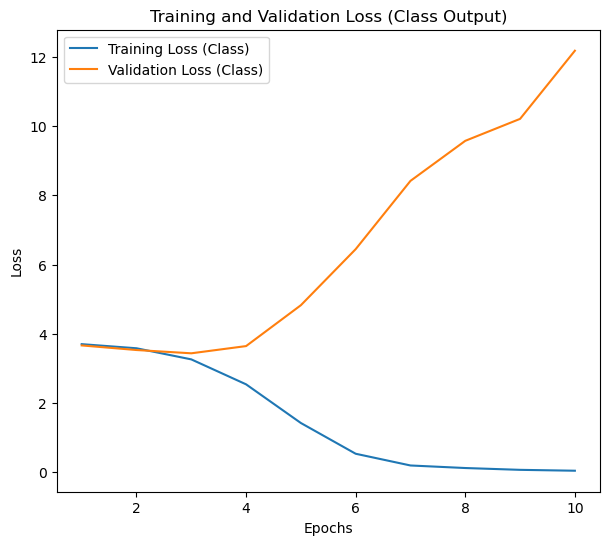

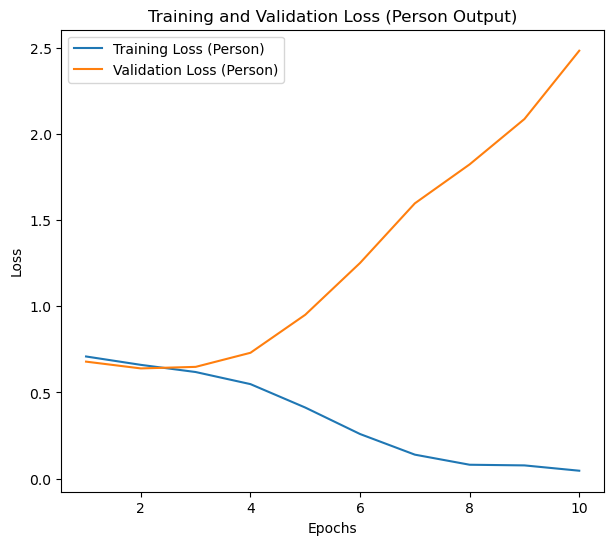

In [23]:
plot_history(history)

While the training loss decreases, the validation loss increase substantially. Additionally, we can see that when we visualize some predictions from the baseline model on test_ds, the predicted class is all over the place. This disparity between training and validation have 2 possible causes:
- The training and validation data is different, therefore, no matter what the model learns, it can't improve the score on validation data. 
- The model is overfitting

Thus, in the next step, we will re-evaluate the data, to see if there are any problem with it

### Validate training and prediction data

In [47]:
# Function to see the underlying data in the dataset
def validate_ds(ds):
    image_batch, label_batch = next(iter(ds))

    label1 = label_batch['categorical_output'][0]
    label2 = label_batch['binary_output'][0]
    plt.imshow(image_batch[0])
    print(image_batch[0])
    print(label1)
    print(label2)

tf.Tensor(
[[[0.39786917 0.23316327 0.13512406]
  [0.44116774 0.28640583 0.18374474]
  [0.37324804 0.22815    0.12226765]
  ...
  [0.29302981 0.24945982 0.18031839]
  [0.30727237 0.26998246 0.20398104]
  [0.20856331 0.17127338 0.10527199]]

 [[0.40216464 0.23945454 0.13542792]
  [0.42615423 0.2730317  0.16473965]
  [0.40826082 0.26316276 0.15328881]
  ...
  [0.29869857 0.24365658 0.18689886]
  [0.23434801 0.179306   0.12254829]
  [0.13592277 0.08088077 0.02775829]]

 [[0.39112896 0.23034462 0.11792718]
  [0.416863   0.26532236 0.15159689]
  [0.4533476  0.30824956 0.19452406]
  ...
  [0.35455227 0.284917   0.23738168]
  [0.22526431 0.1492139  0.10488616]
  [0.19121371 0.11516328 0.07191975]]

 ...

 [[0.99215686 0.99607843 0.972549  ]
  [0.99607843 1.         0.9764706 ]
  [0.99229693 1.         0.9802521 ]
  ...
  [0.13725491 0.13347335 0.12563021]
  [0.13725491 0.13725491 0.12941177]
  [0.13725491 0.13725491 0.13202526]]

 [[0.99215686 0.99607843 0.96869737]
  [0.99607843 1.         0

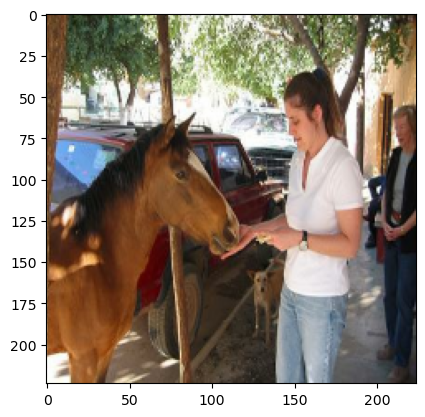

In [48]:
validate_ds(train_ds)

tf.Tensor(
[[[0.32095462 0.15726666 0.09196303]
  [0.3308123  0.14971988 0.08441126]
  [0.35173947 0.16364421 0.08526035]
  ...
  [0.5261555  0.5496849  0.5496849 ]
  [0.5261555  0.5496849  0.5496849 ]
  [0.5257516  0.549281   0.549281  ]]

 [[0.3286977  0.16002776 0.10091787]
  [0.33245173 0.15135929 0.08721364]
  [0.34859946 0.1605042  0.08235294]
  ...
  [0.53140754 0.55493695 0.55493695]
  [0.53140754 0.55493695 0.55493695]
  [0.52902657 0.552556   0.552556  ]]

 [[0.3317927  0.15947755 0.10779562]
  [0.33343965 0.15294118 0.09271584]
  [0.34206557 0.15729667 0.08579807]
  ...
  [0.5367784  0.5603078  0.5603078 ]
  [0.539986   0.5635154  0.5635154 ]
  [0.5362983  0.5598277  0.5598277 ]]

 ...

 [[0.13310078 0.0337535  0.02852518]
  [0.12146492 0.02815126 0.02020312]
  [0.12307433 0.03893558 0.02776614]
  ...
  [0.14814429 0.04618351 0.04226194]
  [0.13735998 0.03539919 0.03147763]
  [0.13940202 0.04267088 0.03613449]]

 [[0.14266106 0.0368486  0.03292703]
  [0.134489   0.0300771  0

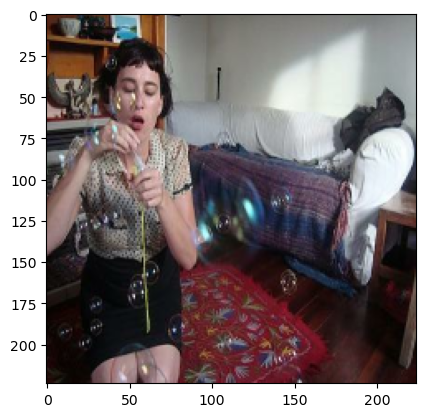

In [49]:
validate_ds(test_ds)

When inspecting the data type, shape of the data and the label, as well as plotting the images out, it seems there are no problem with the data as all seems to be the same. Thus, it is likely the extremely high training f1 score and the extremely low f1 score are caused by overfitting. Additionally, we can see that in the first few epochs, the val loss was decreasing until it starts to shoot up, this also implies the model starting to memorize the training data. Therefore, in the next sections, we will improve the model by reducing the overfitting problem



## Model Regularization

### Transfer learning TODO: Find which pretrained model to use

Given the limited size of our dataset, leveraging transfer learning is crucial. By utilizing models pre-trained on extensive datasets like ImageNet, we can take advantage of the learned features and robust weights, enabling our model to generalize better with our smaller dataset. This will not only accelerates training but also significantly enhances performance, especially when data scarcity could otherwise hinder the model’s ability to learn complex patterns effectively. In this case, we will use Resnet 50 that was trained on ImageNet as it has one of the highest training accuracy. Additionally, the model will have 2 outputs corresponding to Class label and MoreThanOnePerson label the model have to predict.

In [8]:
input_shape = (WIDTH, HEIGHT, 3)

In [25]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

input_layer = tf.keras.Input(shape=input_shape)

x = base_model(input_layer, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)

output_categorical = layers.Dense(40, activation='softmax', name='categorical_output')(x)  

output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

# Step 6: Create the model
pretrained = models.Model(inputs=input_layer, outputs=[output_categorical, output_binary])

# Step 7: Compile the model
pretrained.compile(optimizer='adam',
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['xception[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

In [26]:
history = pretrained.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100


113/113 [==============================] - 17s 131ms/step - loss: 2.4914 - categorical_output_loss: 1.8784 - binary_output_loss: 0.6131 - categorical_output_accuracy: 0.5400 - binary_output_precision: 0.6172 - val_loss: 1.6956 - val_categorical_output_loss: 1.1181 - val_binary_output_loss: 0.5775 - val_categorical_output_accuracy: 0.6800 - val_binary_output_precision: 0.5407
Epoch 2/100
113/113 [==============================] - 14s 124ms/step - loss: 1.3906 - categorical_output_loss: 0.8813 - binary_output_loss: 0.5093 - categorical_output_accuracy: 0.7489 - binary_output_precision: 0.7144 - val_loss: 1.5744 - val_categorical_output_loss: 1.0155 - val_binary_output_loss: 0.5589 - val_categorical_output_accuracy: 0.7089 - val_binary_output_precision: 0.7821
Epoch 3/100
113/113 [==============================] - 14s 125ms/step - loss: 1.1136 - categorical_output_loss: 0.6481 - binary_output_loss: 0.4655 - categorical_output_accuracy: 0.8083 - binary_output_precision: 0.7484 - val_loss: 

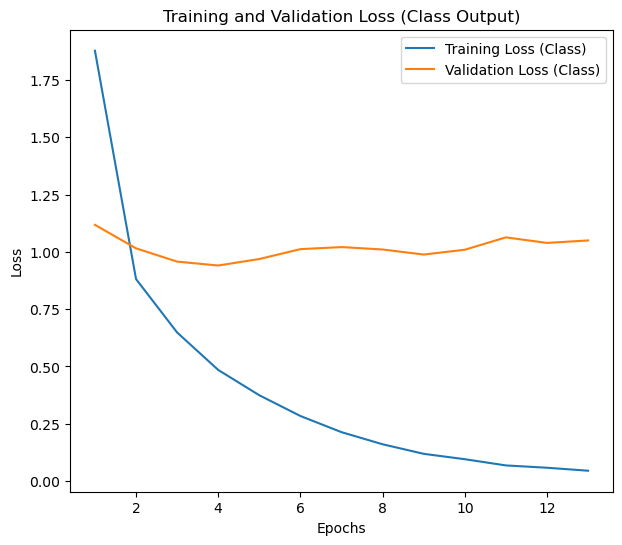

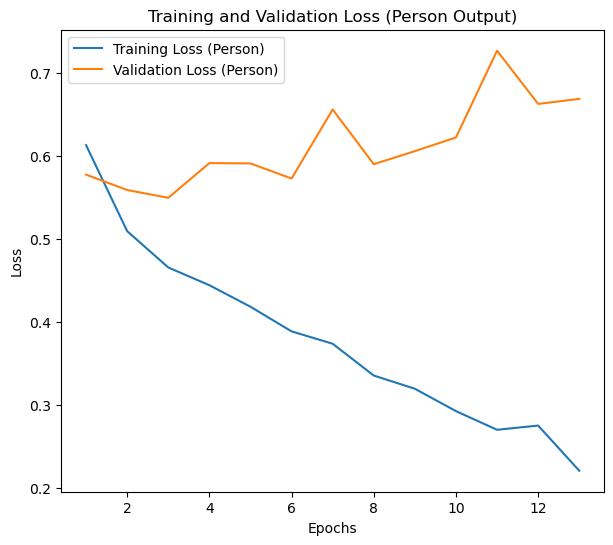

In [28]:
plot_history(history)

Even though in the first few epochs, both training and validation loss decrease together for the Class label, the validation loss stops decreasing. As for the MoreThanOnePerson label, although the training loss decreases, the validation loss does not. This shows that the model is overfitting and possibly focusing on non-informative features that only improve performance on the training set. Despite this, the validation accuracy for both labels are quite decent, standing at 0.7

Therefore, in the next step, we will employ more sophisticated techniques to increase the accuracy of the model. One such technique is the use of a Channel Attention Module, which approach was used in this document: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8965014&casa_token=xq1eEpV9TkEAAAAA:kDARk_Qz4fqI_BudiP0m6vlUeGsS4wXloHavsQBfJLzYp4NMfsLu8pGa93N7Ht2yGETTVNff.

A Channel Attention Module enhances the model's ability to focus on the most informative features across the different channels of the feature maps. By adaptively re-weighting the importance of each channel, the module allows the model to prioritize the most relevant features while suppressing less useful ones. This can be particularly beneficial in scenarios with limited labeled data, where the model might otherwise overfit by focusing on noise or irrelevant patterns. By guiding the model to focus on more meaningful features, the Channel Attention Module can help reduce overfitting, leading to better generalization on the validation set.

Additionally, we can see that the loss is unstable, therefore, we will use a smaller learning rate for the optimizer

### Channel Attention Module TODO

There are 2 documents which I foud have the same idea of using channel attention modules. However, the 2 papers have different implementations for the module, as well as different overall design. Therefore, to find the suitable module design for our specific case, we will train 2 models with 2 different attention modules to compare the performance between the 2 designs, and then choose the best one for our situation

#### Design 1

The first design uses

In [90]:
def channel_attention_1(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = layers.Dense(channel // ratio,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    # Reshape to fit Conv layers
    
    x = layers.GlobalAveragePooling2D()(input_feature)
    
    x = shared_layer_one(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = shared_layer_two(x)
    x = layers.Activation('relu')(x)
    
    return layers.Multiply()([input_feature, x])

In [169]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

input_layer = tf.keras.Input(shape=input_shape)

x = base_model(input_layer, training=False)

x = channel_attention_1(x)
x = layers.GlobalAveragePooling2D()(x)

class_branch = layers.Dropout(0.4)(x)
class_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(40, activation='softmax', name='categorical_output')(class_branch)

person_branch = layers.Dropout(0.4)(x)
person_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(1, activation='sigmoid', name='binary_output')(person_branch)

design_1 = models.Model(inputs=input_layer, outputs=[class_branch, person_branch])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

design_1.compile(optimizer=optimizer,
            loss={'categorical_output': 'sparse_categorical_crossentropy',
                  'binary_output': 'binary_crossentropy'},
            metrics={'categorical_output': 'accuracy',
                  'binary_output': tf.keras.metrics.Precision(name='precision')})

design_1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_24[0][0]']               
                                                                                                  
 global_average_pooling2d_43 (G  (None, 2048)        0           ['xception[0][0]']               
 lobalAveragePooling2D)                                                                           
                                                                                           

In [170]:
design_1_history = design_1.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100
113/113 [==============================] - 19s 133ms/step - loss: 4.3940 - categorical_output_loss: 3.7113 - binary_output_loss: 0.6828 - categorical_output_accuracy: 0.0319 - binary_output_precision: 0.3997 - val_loss: 4.2906 - val_categorical_output_loss: 3.6334 - val_binary_output_loss: 0.6573 - val_categorical_output_accuracy: 0.0989 - val_binary_output_precision: 0.6250
Epoch 2/100
113/113 [==============================] - 15s 127ms/step - loss: 4.2540 - categorical_output_loss: 3.5969 - binary_output_loss: 0.6571 - categorical_output_accuracy: 0.0567 - binary_output_precision: 0.4567 - val_loss: 4.1622 - val_categorical_output_loss: 3.5172 - val_binary_output_loss: 0.6450 - val_categorical_output_accuracy: 0.2056 - val_binary_output_precision: 0.5897
Epoch 3/100
113/113 [==============================] - 15s 129ms/step - loss: 4.1222 - categorical_output_loss: 3.4754 - binary_output_loss: 0.6468 - categorical_output_accuracy: 0.0842 - binary_output_precision: 0.5192 

#### Design 2

The second design uses

In [33]:
def channel_attention_2(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = layers.Conv2D(filters=channel // ratio,
                                    kernel_size=(1, 1),
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    shared_layer_two = layers.Conv2D(filters=channel,
                                    kernel_size=(1, 1),
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    
    x = layers.GlobalAveragePooling2D()(input_feature)
    
    # Reshape to fit Conv layers
    x = layers.Reshape((1, 1, channel))(x)
    
    x = shared_layer_one(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = shared_layer_two(x)
    x = layers.Activation('sigmoid')(x)
    
    return layers.Multiply()([input_feature, x])

In [35]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

input_layer = tf.keras.Input(shape=input_shape)

x = base_model(input_layer, training=False)

x = channel_attention_2(x)
x = layers.GlobalAveragePooling2D()(x)

class_branch = layers.Dropout(0.4)(x)
class_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(40, activation='softmax', name='categorical_output')(class_branch)

person_branch = layers.Dropout(0.4)(x)
person_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(1, activation='sigmoid', name='binary_output')(person_branch)

design_2 = models.Model(inputs=input_layer, outputs=[class_branch, person_branch])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

design_2.compile(optimizer=optimizer,
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

In [36]:
design_2_history = design_2.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100


113/113 [==============================] - 18s 132ms/step - loss: 4.3809 - categorical_output_loss: 3.7070 - binary_output_loss: 0.6739 - categorical_output_accuracy: 0.0308 - binary_output_precision: 0.4099 - val_loss: 4.2877 - val_categorical_output_loss: 3.6462 - val_binary_output_loss: 0.6415 - val_categorical_output_accuracy: 0.0667 - val_binary_output_precision: 0.0000e+00
Epoch 2/100
113/113 [==============================] - 14s 126ms/step - loss: 4.2820 - categorical_output_loss: 3.6279 - binary_output_loss: 0.6542 - categorical_output_accuracy: 0.0486 - binary_output_precision: 0.4613 - val_loss: 4.1879 - val_categorical_output_loss: 3.5554 - val_binary_output_loss: 0.6324 - val_categorical_output_accuracy: 0.1178 - val_binary_output_precision: 0.7333
Epoch 3/100
113/113 [==============================] - 14s 125ms/step - loss: 4.1776 - categorical_output_loss: 3.5449 - binary_output_loss: 0.6327 - categorical_output_accuracy: 0.0714 - binary_output_precision: 0.5385 - val_lo

#### Design 3

In [244]:
def channel_attention_3(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_dense_one = layers.Dense(channel // ratio, 
                                    activation='relu', 
                                    kernel_initializer='he_normal', 
                                    use_bias=True, 
                                    bias_initializer='zeros')
    shared_dense_two = layers.Dense(channel, 
                                    kernel_initializer='he_normal', 
                                    use_bias=True, 
                                    bias_initializer='zeros')
    
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)
    
    attention = layers.Add()([avg_pool, max_pool])
    attention = layers.Activation('sigmoid')(attention)
    
    return layers.Multiply()([input_feature, attention])

In [245]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

input_layer = tf.keras.Input(shape=input_shape)

x = base_model(input_layer, training=False)

x = channel_attention_3(x)
x = layers.GlobalAveragePooling2D()(x)

class_branch = layers.Dropout(0.4)(x)
class_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(class_branch)
class_branch = layers.Dropout(0.4)(class_branch)
class_branch = layers.Dense(40, activation='softmax', name='categorical_output')(class_branch)

person_branch = layers.Dropout(0.4)(x)
person_branch = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(person_branch)
person_branch = layers.Dropout(0.4)(person_branch)
person_branch = layers.Dense(1, activation='sigmoid', name='binary_output')(person_branch)

design_3 = models.Model(inputs=input_layer, outputs=[class_branch, person_branch])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

design_3.compile(optimizer=optimizer,
              loss={'categorical_output': 'sparse_categorical_crossentropy',
                    'binary_output': 'binary_crossentropy'},
              metrics={'categorical_output': 'accuracy',
                       'binary_output': tf.keras.metrics.Precision(name='precision')})

In [246]:
design_3_history = design_3.fit(train_ds, epochs=100, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/100
113/113 [==============================] - 22s 150ms/step - loss: 4.3571 - categorical_output_loss: 3.6760 - binary_output_loss: 0.6811 - categorical_output_accuracy: 0.0381 - binary_output_precision: 0.3719 - val_loss: 4.2519 - val_categorical_output_loss: 3.6080 - val_binary_output_loss: 0.6439 - val_categorical_output_accuracy: 0.1211 - val_binary_output_precision: 0.3333
Epoch 2/100
113/113 [==============================] - 16s 138ms/step - loss: 4.2742 - categorical_output_loss: 3.6159 - binary_output_loss: 0.6583 - categorical_output_accuracy: 0.0506 - binary_output_precision: 0.4585 - val_loss: 4.1568 - val_categorical_output_loss: 3.5191 - val_binary_output_loss: 0.6377 - val_categorical_output_accuracy: 0.1811 - val_binary_output_precision: 0.8000
Epoch 3/100
113/113 [==============================] - 16s 138ms/step - loss: 4.1708 - categorical_output_loss: 3.5193 - binary_output_loss: 0.6514 - categorical_output_accuracy: 0.0864 - binary_output_precision: 0.4881 

#### Compare

In [ ]:
# Compare 3 designs training
fig, axs = plt.subplots(3, figsize=(8, 10))

axs[0].plot(design_1_history.history['loss'], label='Design 1')
axs[0].plot(design_2_history.history['loss'], label='Design 2')
axs[0].plot(design_3_history.history['loss'], label='Design 3')
axs[0].set_title('Training Loss')

axs[1].plot(design_1_history.history['val_categorical_output_accuracy'], label='Design 1')
axs[1].plot(design_2_history.history['val_categorical_output_accuracy'], label='Design 2')
axs[1].plot(design_3_history.history['val_categorical_output_accuracy'], label='Design 3')
axs[1].set_title('Categorical Output Accuracy')

axs[2].plot(design_1_history.history['val_binary_output_precision'], label='Design 1')
axs[2].plot(design_2_history.history['val_binary_output_precision'], label='Design 2')
axs[2].plot(design_3_history.history['val_binary_output_precision'], label='Design 3')
axs[2].set_title('Binary Output Precision')

for ax in axs:
    ax.set_xlabel('Epoch')
    ax.legend()

plt.tight_layout()
plt.show()

The first design were able to achieve higher accuracy, and lower loss in the same number of training epochs than the second design. Therefore, for the following models, we will use the first design 

We can see that despite using attention module on top of transfer learning has greatly reduce overfitting in both model. Specifically, for the categorical output, the model achieved a much higher accuracy than traing. However, the same could not be said for the second output as the validation accuracy bounce around 0.75 where as the training accuracy increase to 96%. Therefore, in the next step, to reduce overfitting, we will apply data augmentation and l2 regularizer. Additionally, we will add a learning rate scheduler so that when the binary output starts to plateau, it can still continue improving

### TESTING

Try skip connection, spatial attention modules, combine spatial and channel attention modules, auxiliary output for branch 1

In [242]:
# See the correlation between class and high level category
crosstab = pd.crosstab(development_data['HighLevelCategory'], development_data['Class'])
print(crosstab)

Class                        0    1   2   3    4    5   6   7    8    9   ...  \
HighLevelCategory                                                         ...   
AnimalCare                    0    0   0   0    0    0   0   0    0  138  ...   
Artistic_MusicalActivities    0    0   0   0    0    0   0   0    0    0  ...   
Communication_Technology      0    0   0   0    0    0   0   0    0    0  ...   
HouseholdActivities           0    0   0  92    0  153   0  75    0    0  ...   
MaintenanceRepair             0    0   0   0    0    0  78   0    0    0  ...   
Observation_Exploration       0    0   0   0    0    0   0   0    0    0  ...   
OutdoorActivities             0    0   0   0  155    0   0   0    0    0  ...   
PersonalCare_Hygiene          0    0  73   0    0    0   0   0    0    0  ...   
Social_LeisureActivities    222  132   0   0    0    0   0   0  131    0  ...   
Sports_Recreation             0    0   0   0    0    0   0   0    0    0  ...   

Class                      

In [81]:
future_data = pd.read_csv('future_data_2024.csv')
development_data = pd.read_csv('train_data_2024.csv')

image_dir = './Images/'

# Get the file paths for each image record
development_data['FilePath'] = development_data['FileName'].apply(lambda x: os.path.join(image_dir, x))
future_data['FilePath'] = future_data['FileName'].apply(lambda x: os.path.join(image_dir, x))

In [82]:
# Currently, the Class and MoreThanOnePerson labels are strings, so we one-hot encode them after splitting
class_encoder = LabelEncoder()
cat_encoder = LabelEncoder()
development_data['Class'] = class_encoder.fit_transform(development_data['Class'])
development_data['MoreThanOnePerson'] = development_data['MoreThanOnePerson'].map({'YES': 1, 'NO': 0})
development_data['HighLevelCategory'] = cat_encoder.fit_transform(development_data['HighLevelCategory'])

In [83]:
class_mapping = dict(enumerate(class_encoder.classes_))
binary_mapping = {1: 'YES', 0: 'NO'}
cat_mapping = dict(enumerate(cat_encoder.classes_))

In [84]:
def load_image(filepath, label=None, augment=False):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [WIDTH, HEIGHT]) 
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    
    # Augment data
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.8, 1.2)
    
    if label is None:
        return image
    else: 
        return image, label

In [85]:
train, test = train_test_split(development_data, test_size=0.2, random_state=RANDOM_SEED, stratify=development_data['Class'])

In [86]:
train_ds = tf.data.Dataset.from_tensor_slices((train['FilePath'], {'categorical_output': train['Class'], 'binary_output': train['MoreThanOnePerson'], 'aux_output': train['HighLevelCategory']}))
train_ds = train_ds.map(lambda x, y: load_image(x, y, augment=True)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test['FilePath'], {'categorical_output': test['Class'], 'binary_output': test['MoreThanOnePerson'], 'aux_output': test['HighLevelCategory']}))
test_ds = test_ds.map(lambda x, y: load_image(x, y)).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

future_ds = tf.data.Dataset.from_tensor_slices((future_data['FilePath']))
future_ds = future_ds.map(lambda x: load_image(x, None)).shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [87]:
# Cbam block
def spatial_attention(input_feature):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid', 
                              kernel_initializer='he_normal', use_bias=False)(concat)
    
    return layers.Multiply()([input_feature, attention])

def cbam_block(input_feature, ratio=8):
    # Channel attention
    channel_att = channel_attention_1(input_feature, ratio)
    
    # Spatial attention
    spatial_att = spatial_attention(channel_att)
    
    return spatial_att

def atrous_conv_layer(inputs, filters, kernel_size, rate):
    return tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
    dilation_rate=rate, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)

In [95]:
base_model_cat = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_cat.trainable = False

# Second pre-trained model (MobileNetV2) for the binary output
base_model_bin = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_bin.trainable = False

# Input layer
input_layer = tf.keras.Input(shape=input_shape)

# Categorical branch
x_cat = base_model_cat(input_layer, training=False)
x_cat  = spatial_attention(x_cat)
x_cat = layers.GlobalAveragePooling2D()(x_cat)

x_cat = layers.Dropout(0.4)(x_cat)
x_cat = layers.Dense(64, kernel_initializer='he_normal')(x_cat)
x_cat = layers.Activation('relu')(x_cat)
x_cat_1 = layers.Dropout(0.4)(x_cat)
x_cat = layers.Dense(32, kernel_initializer='he_normal')(x_cat_1)
x_cat = layers.Activation('relu')(x_cat)
x_cat = layers.Dropout(0.4)(x_cat)
class_output = layers.Dense(40, activation='softmax', name='categorical_output')(x_cat)

# Binary branch
x_bin = base_model_bin(input_layer, training=False)
# Atrous convolution
x_bin = atrous_conv_layer(x_bin, 32, (3, 3), rate=2)
x_bin = atrous_conv_layer(x_bin, 32, (3, 3), rate=4)
x_bin = layers.GlobalAveragePooling2D()(x_bin)

x_bin = layers.Dropout(0.4)(x_bin)
x_bin = layers.Dense(8, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_bin)
x_bin = layers.Dropout(0.4)(x_bin)
x_bin = layers.Dense(8, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x_bin)
x_bin = layers.Dropout(0.4)(x_bin)
binary_output = layers.Dense(1, activation='sigmoid', name='binary_output')(x_bin)

aux = layers.Dense(8, kernel_initializer='he_normal', activation='relu')(x_cat_1)
aux = layers.Dropout(0.4)(aux)
aux = layers.Dense(10, activation='softmax', name='aux_output')(aux)

# Final model
test_model = models.Model(inputs=input_layer, outputs=[class_output, binary_output, aux])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
test_model.compile(optimizer=optimizer,
                   loss={'categorical_output': 'sparse_categorical_crossentropy',
                         'binary_output': 'binary_crossentropy', 
                         'aux_output': 'sparse_categorical_crossentropy'},
                  loss_weights={'categorical_output': 1.0,   # Main task
                              'binary_output': 1.0,        # Binary task
                              'aux_output': 0.5},  # Auxiliary task
                   metrics={'categorical_output': 'accuracy',
                            'binary_output': tf.keras.metrics.AUC(name='auc'),
                            'aux_output': 'accuracy'})

# Model summary
test_model.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_78 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 7, 7, 2048)   20861480    ['input_78[0][0]']               
                                                                                                  
 lambda_50 (Lambda)             (None, 7, 7, 1)      0           ['xception[0][0]']               
                                                                                                  
 lambda_51 (Lambda)             (None, 7, 7, 1)      0           ['xception[0][0]']        

In [94]:
history = test_model.fit(train_ds, epochs=200, callbacks=get_cbs(), validation_data=test_ds)

Epoch 1/200
113/113 [==============================] - 29s 197ms/step - loss: 5.9138 - categorical_output_loss: 3.6911 - binary_output_loss: 0.7651 - aux_output_loss: 2.3227 - categorical_output_accuracy: 0.0297 - binary_output_auc: 0.4983 - aux_output_accuracy: 0.1211 - val_loss: 5.7495 - val_categorical_output_loss: 3.6537 - val_binary_output_loss: 0.6857 - val_aux_output_loss: 2.2332 - val_categorical_output_accuracy: 0.0789 - val_binary_output_auc: 0.5147 - val_aux_output_accuracy: 0.2889
Epoch 2/200
113/113 [==============================] - 22s 170ms/step - loss: 5.7444 - categorical_output_loss: 3.6422 - binary_output_loss: 0.7063 - aux_output_loss: 2.2100 - categorical_output_accuracy: 0.0394 - binary_output_auc: 0.4888 - aux_output_accuracy: 0.2031 - val_loss: 5.5957 - val_categorical_output_loss: 3.5750 - val_binary_output_loss: 0.6870 - val_aux_output_loss: 2.0915 - val_categorical_output_accuracy: 0.1422 - val_binary_output_auc: 0.5014 - val_aux_output_accuracy: 0.3500
Epoc

In [29]:
test_model.evaluate(test_ds)

29/29 [==============================] - 4s 127ms/step - loss: 1.8763 - categorical_output_loss: 1.0897 - binary_output_loss: 0.4633 - aux_output_loss: 0.6465 - categorical_output_accuracy: 0.6922 - binary_output_auc: 0.8404 - aux_output_accuracy: 0.7933


[1.876280665397644,
 1.089742660522461,
 0.4632715582847595,
 0.6465325355529785,
 0.6922222375869751,
 0.8404464721679688,
 0.7933333516120911]